In [1]:
import pandas as pd

before_df = pd.read_csv("../data/diner_category_raw.csv")
after_df = pd.read_csv("../data/diner_category_modified.csv")

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc  ### 이 줄과
rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 

In [15]:
# 중분류 카테고리 변화 분석 및 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict, Counter
import warnings

# 한글 폰트 설정
try:
    from matplotlib import rc
    rc('font', family='AppleGothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    pass

warnings.filterwarnings('ignore')


In [16]:
# 1. Before -> After 매핑 분석
# 같은 diner_idx를 기준으로 매핑 관계 생성
mapping_df = pd.merge(
    before_df[['diner_idx', 'diner_category_middle']],
    after_df[['diner_idx', 'diner_category_middle']],
    on='diner_idx',
    suffixes=('_before', '_after')
)

# 결측치 제거
mapping_df = mapping_df.dropna(subset=['diner_category_middle_before', 'diner_category_middle_after'])

# 매핑 관계 집계
mapping_counts = mapping_df.groupby(['diner_category_middle_before', 'diner_category_middle_after']).size().reset_index(name='count')
mapping_counts = mapping_counts.sort_values('count', ascending=False)

print("=" * 80)
print("중분류 카테고리 변화 매핑 분석")
print("=" * 80)
print(f"\n총 매핑 관계 수: {len(mapping_counts)}")
print(f"\n[Top 20 매핑 관계]")
print(mapping_counts.head(20).to_string(index=False))


중분류 카테고리 변화 매핑 분석

총 매핑 관계 수: 286

[Top 20 매핑 관계]
diner_category_middle_before diner_category_middle_after  count
                       육류,고기                       육류/고기  34713
                       해물,생선                       해물/생선  17445
                     호프,요리주점                          호프  13108
                     제과,베이커리                     제과/베이커리  10416
                        중국요리                        중국요리   7502
                          국수                          국수   5551
                       커피전문점                          커피   5417
                      실내포장마차                        포장마차   4971
                          피자                          피자   4427
                      돈까스,우동                         돈까스   3990
                         떡볶이                   떡볶이/순대/튀김   3483
                        떡,한과                           떡   3346
                       일본식주점                       일본식주점   3075
                          국밥                        탕/

In [17]:
# 2. 변화 패턴 분석
# - 통합: 여러 Before가 하나의 After로
# - 분리: 하나의 Before가 여러 After로
# - 이름 변경: 1:1 매핑
# - 유지: 동일

# Before별로 After 분포 확인
before_to_after = defaultdict(lambda: defaultdict(int))
for _, row in mapping_df.iterrows():
    before = row['diner_category_middle_before']
    after = row['diner_category_middle_after']
    before_to_after[before][after] += 1

# After별로 Before 분포 확인
after_to_before = defaultdict(lambda: defaultdict(int))
for _, row in mapping_df.iterrows():
    before = row['diner_category_middle_before']
    after = row['diner_category_middle_after']
    after_to_before[after][before] += 1

# 변화 패턴 분류
patterns = {
    '통합': [],  # 여러 Before -> 하나의 After
    '분리': [],  # 하나의 Before -> 여러 After
    '1:1_변경': [],  # 1:1 매핑이지만 이름이 다른 경우
    '유지': []  # 동일한 이름
}

for before, after_dict in before_to_after.items():
    after_list = list(after_dict.keys())
    if len(after_list) == 1:
        after = after_list[0]
        if before == after:
            patterns['유지'].append((before, after, sum(after_dict.values())))
        else:
            patterns['1:1_변경'].append((before, after, sum(after_dict.values())))
    else:
        # 분리된 경우
        for after, count in after_dict.items():
            patterns['분리'].append((before, after, count))

for after, before_dict in after_to_before.items():
    if len(before_dict) > 1:
        # 통합된 경우
        before_list = list(before_dict.keys())
        total_count = sum(before_dict.values())
        patterns['통합'].append((tuple(before_list), after, total_count))

print("\n[변화 패턴 요약]")
print(f"유지: {len(patterns['유지'])}개")
print(f"1:1 변경: {len(patterns['1:1_변경'])}개")
print(f"통합: {len(patterns['통합'])}개")
print(f"분리: {len(patterns['분리'])}개")

print("\n[Top 10 통합 사례]")
sorted_consolidations = sorted(patterns['통합'], key=lambda x: x[2], reverse=True)[:10]
for before_list, after, count in sorted_consolidations:
    print(f"{', '.join(before_list)} -> {after} ({count:,}개)")

print("\n[Top 10 1:1 변경 사례]")
sorted_changes = sorted(patterns['1:1_변경'], key=lambda x: x[2], reverse=True)[:10]
for before, after, count in sorted_changes:
    print(f"{before} -> {after} ({count:,}개)")



[변화 패턴 요약]
유지: 25개
1:1 변경: 261개
통합: 31개
분리: 0개

[Top 10 통합 사례]
육류,고기, 한식뷔페, 고기뷔페, 오봉집, 승도리네 곱도리탕, 천복집흑염소, 제육의법칙 -> 육류/고기 (35,944개)
해물,생선, 해산물, 해탄, 백연게장 -> 해물/생선 (17,536개)
호프,요리주점, 파이널나인 -> 호프 (13,112개)
감자탕, 찌개,전골, 국밥, 곰탕, 해장국, 사철탕,영양탕, 설렁탕 -> 탕/국밥 (10,424개)
커피전문점, 테마카페, 아마스빈, 벌크커피, 브런치빈, 커피마마퀸, 아임일리터, 날쌘카페, 반달커피, 카페마마스 -> 커피 (8,133개)
냉면, 국수, 수제비 -> 국수 (7,181개)
피자, 치킨과바람피자, 투가이즈피자앤치킨 -> 피자 (4,438개)
KFC, 멕시카나치킨, 부어치킨, BHC치킨, 오븐마루치킨, 치킨매니아, 다사랑치킨, 호치킨, 맥시칸치킨, 맘스터치, 자담치킨, 깐부치킨, 치킨마루, 치킨뱅이, 호식이두마리치킨, 굽네치킨, 치킨플러스, 678치킨, 썬더치킨, 보드람치킨, 푸라닭치킨, 오태식해바라기치킨, 당신은지금치킨이땡긴다, 디디치킨, 네네치킨, 교촌치킨, 바른치킨, 공만치킨, 두리아치킨, 본스치킨, 충만치킨, 이춘봉인생치킨, 땅땅치킨, 림스치킨, 돈치킨, 둘둘치킨, 야들리애치킨, 티바두마리치킨, 계동치킨, 치킨신드롬, 봉이치킨, 핫썬치킨, 땡큐맘치킨, DK치킨, 모모치킨, 경아두마리치킨, 투존치킨, 기발한치킨, 치킨퐁, 구워더존치킨, 장모님치킨, 작살치킨, 큰통치킨, 치킨의민족, 치킨더홈, 아로하치킨 -> 치킨 (4,248개)
떡볶이, 삼진어묵, 삼첩분식, 배터지는생동까스, 스쿨푸드, 강다짐, 스쿨스토어, 아딸 -> 떡볶이/순대/튀김 (3,650개)
갓튀긴후라이드, 가마치통닭, 명가통닭, BBQ, 페리카나, 60계치킨, 오늘통닭, 처갓집양념치킨, 쌀통닭, 또봉이통닭, 후라이드참잘하는집, 아라치, 노랑통닭, 또래오래, 순살만공격, 누구나홀딱반한닭, 미쳐버린파닭, 순수치킨, 신통치킨, 60

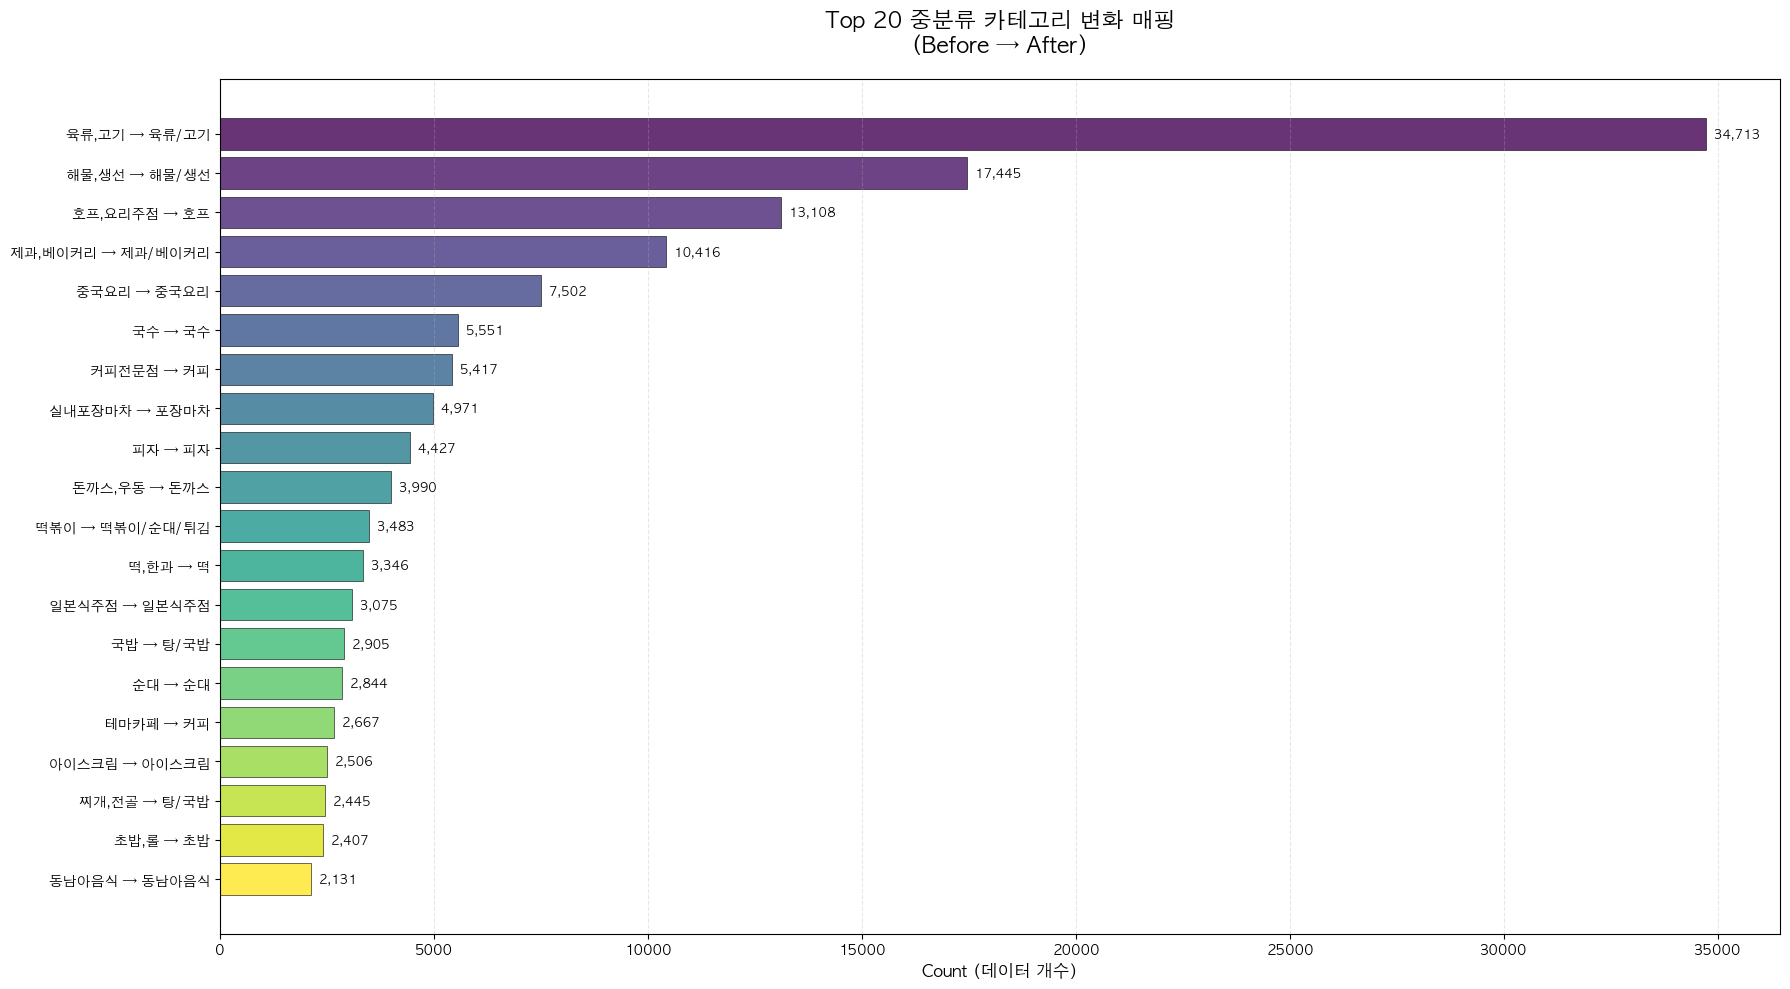

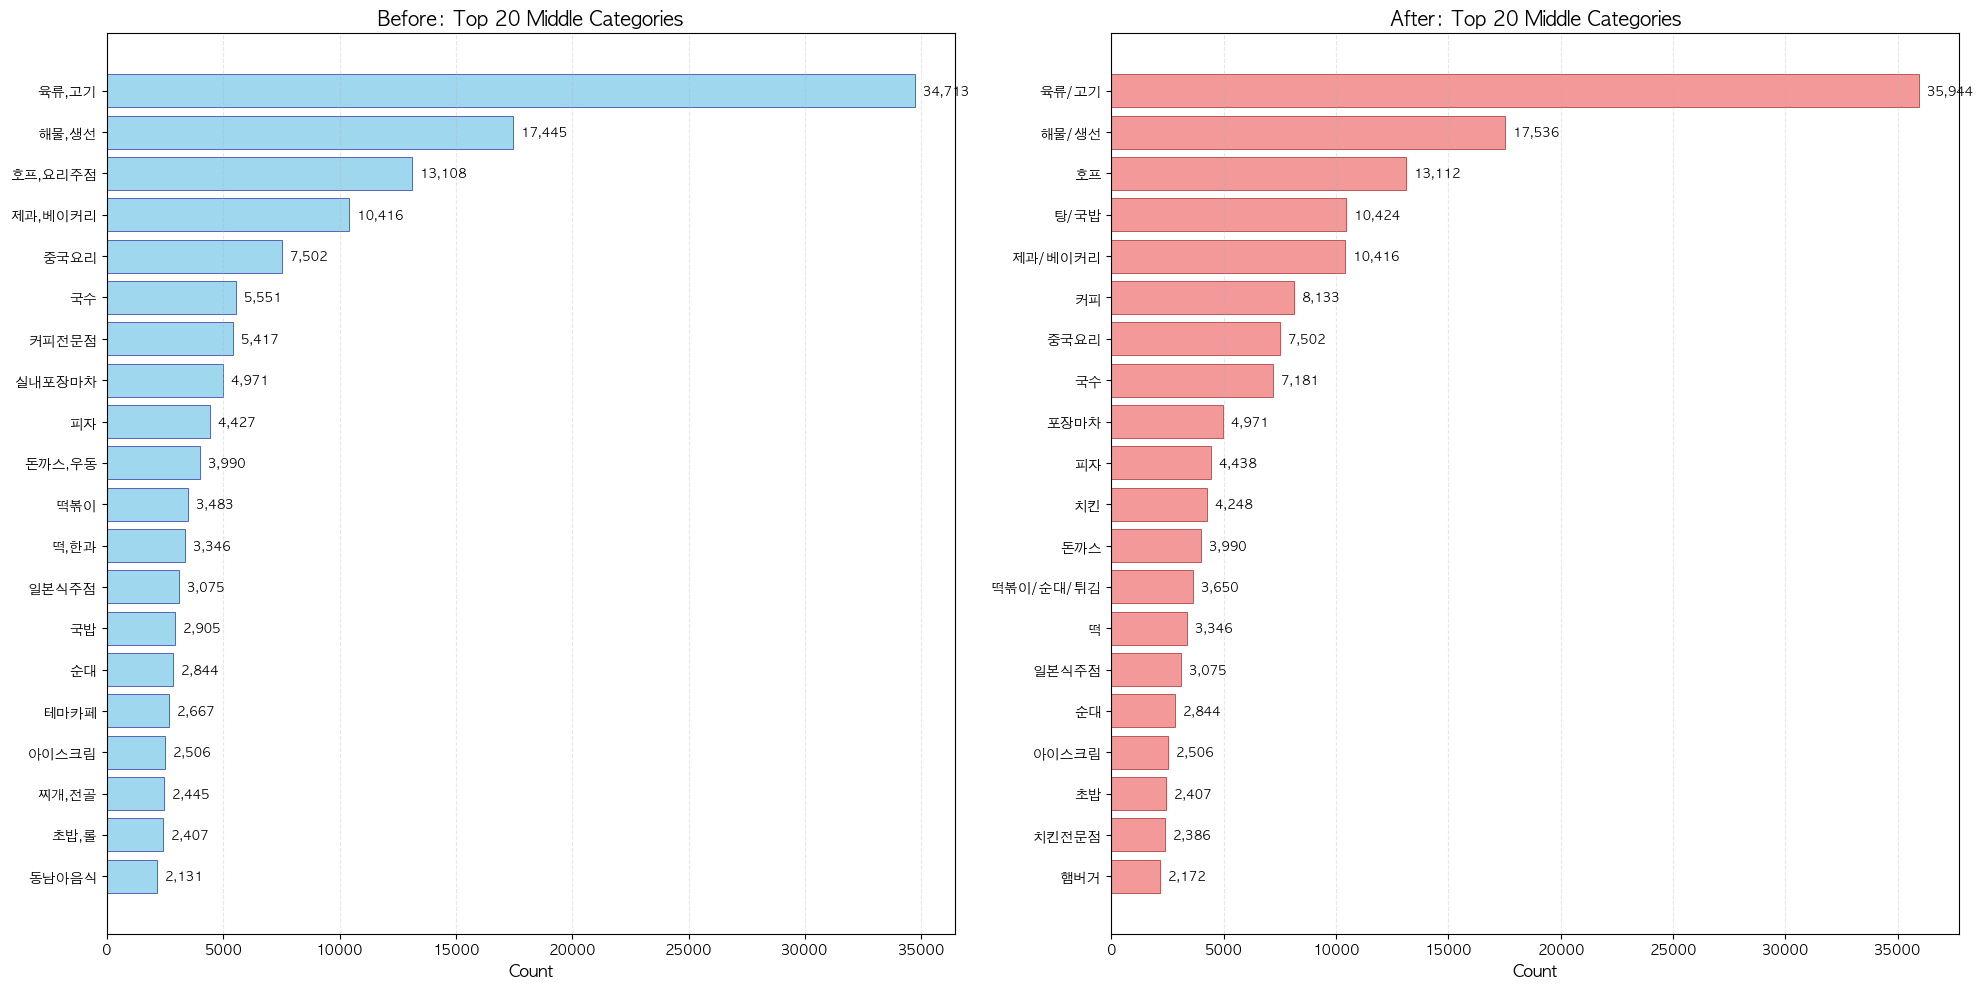

In [20]:
# 3. Before -> After 매핑 관계 시각화 (명확한 플롯)
# 상위 20개 매핑 관계를 명확하게 표시

top_mappings = mapping_counts.head(20).copy()

# 플롯 1: Before -> After 매핑 막대 그래프
fig, ax = plt.subplots(figsize=(18, 10))

# Before -> After 텍스트 생성
mapping_labels = []
for _, row in top_mappings.iterrows():
    before = row['diner_category_middle_before']
    after = row['diner_category_middle_after']
    count = row['count']
    mapping_labels.append(f"{before} → {after}")

# 막대 그래프
y_pos = np.arange(len(top_mappings))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_mappings)))

bars = ax.barh(y_pos, top_mappings['count'].values, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(mapping_labels, fontsize=10)
ax.set_xlabel('Count (데이터 개수)', fontsize=12, fontweight='bold')
ax.set_title('Top 20 중분류 카테고리 변화 매핑\n(Before → After)', fontsize=16, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')

# 값 표시
for i, (idx, row) in enumerate(top_mappings.iterrows()):
    count = row['count']
    ax.text(count, i, f'  {count:,}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# 플롯 2: Before vs After 비교 (나란히)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Before Top 20
before_top20 = mapping_df['diner_category_middle_before'].value_counts().head(20)
axes[0].barh(range(len(before_top20)), before_top20.values, color='skyblue', alpha=0.8, edgecolor='navy', linewidth=0.5)
axes[0].set_yticks(range(len(before_top20)))
axes[0].set_yticklabels(before_top20.index, fontsize=10)
axes[0].set_xlabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Before: Top 20 Middle Categories', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

# 값 표시
for i, v in enumerate(before_top20.values):
    axes[0].text(v, i, f'  {v:,}', va='center', fontsize=9, fontweight='bold')

# After Top 20
after_top20 = mapping_df['diner_category_middle_after'].value_counts().head(20)
axes[1].barh(range(len(after_top20)), after_top20.values, color='lightcoral', alpha=0.8, edgecolor='darkred', linewidth=0.5)
axes[1].set_yticks(range(len(after_top20)))
axes[1].set_yticklabels(after_top20.index, fontsize=10)
axes[1].set_xlabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('After: Top 20 Middle Categories', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

# 값 표시
for i, v in enumerate(after_top20.values):
    axes[1].text(v, i, f'  {v:,}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


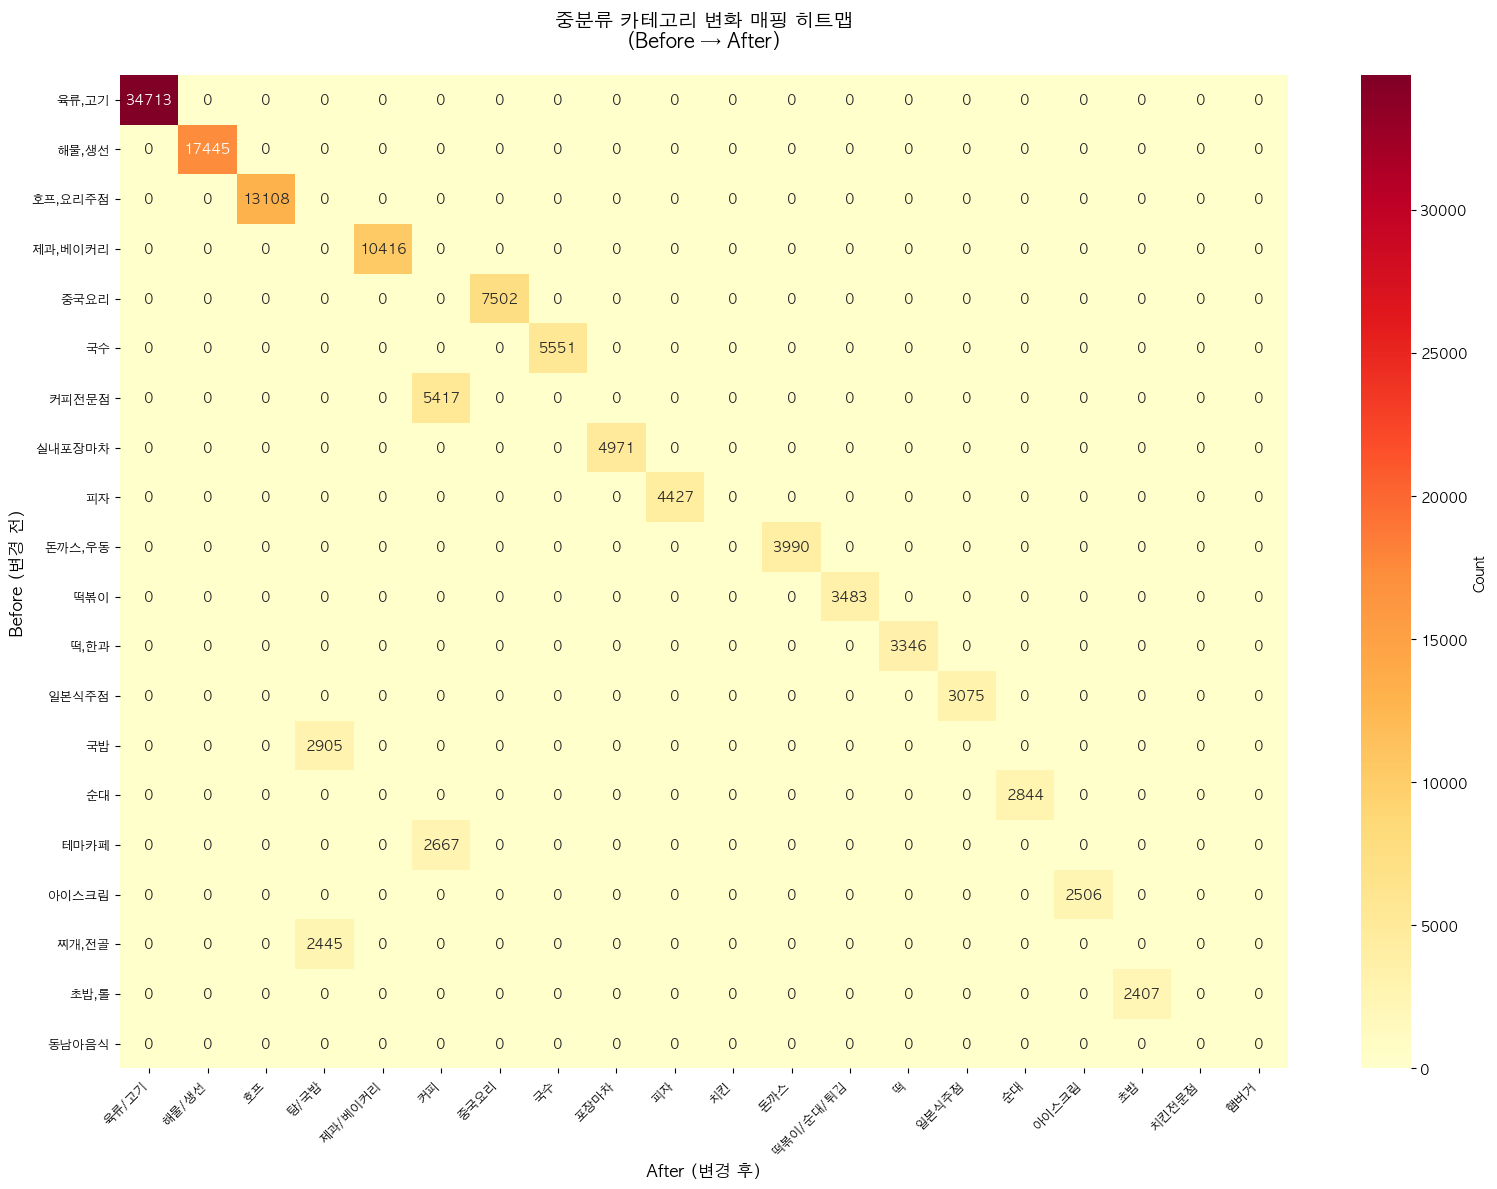

In [19]:
# 4. 히트맵: Before -> After 매핑 강도
# 상위 Before 20개와 상위 After 20개로 제한
top_before = mapping_df['diner_category_middle_before'].value_counts().head(20).index.tolist()
top_after = mapping_df['diner_category_middle_after'].value_counts().head(20).index.tolist()

# 매트릭스 생성
heatmap_data = np.zeros((len(top_before), len(top_after)))
for _, row in mapping_df.iterrows():
    before = row['diner_category_middle_before']
    after = row['diner_category_middle_after']
    if before in top_before and after in top_after:
        i = top_before.index(before)
        j = top_after.index(after)
        heatmap_data[i, j] += 1

# 히트맵 시각화
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(heatmap_data, 
            xticklabels=top_after,
            yticklabels=top_before,
            annot=True, 
            fmt='.0f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_xlabel('After (변경 후)', fontsize=12, fontweight='bold')
ax.set_ylabel('Before (변경 전)', fontsize=12, fontweight='bold')
ax.set_title('중분류 카테고리 변화 매핑 히트맵\n(Before → After)', fontsize=14, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


In [23]:
# 7. 변화 요약 통계
print("=" * 80)
print("중분류 카테고리 변화 요약")
print("=" * 80)

# 카테고리 개수 변화
before_unique = mapping_df['diner_category_middle_before'].nunique()
after_unique = mapping_df['diner_category_middle_after'].nunique()

print(f"\n[카테고리 개수]")
print(f"Before: {before_unique}개")
print(f"After:  {after_unique}개")
print(f"변화:   {after_unique - before_unique:+d}개 ({((after_unique - before_unique) / before_unique * 100):.1f}%)")

# 변화 패턴 통계
total_rows = len(mapping_df)
unchanged = len([x for x in patterns['유지']])
changed = total_rows - unchanged

print(f"\n[변화 통계]")
print(f"총 데이터: {total_rows:,}개")
print(f"유지: {unchanged:,}개 ({unchanged/total_rows*100:.1f}%)")
print(f"변경: {changed:,}개 ({changed/total_rows*100:.1f}%)")

print(f"\n[변화 패턴]")
print(f"1:1 변경: {len(patterns['1:1_변경'])}개")
print(f"통합: {len(patterns['통합'])}개")
print(f"분리: {len(patterns['분리'])}개")

# 가장 많이 통합된 After
if patterns['통합']:
    top_consolidated = max(patterns['통합'], key=lambda x: x[2])
    print(f"\n[가장 큰 통합]")
    print(f"{', '.join(top_consolidated[0])} → {top_consolidated[1]} ({top_consolidated[2]:,}개)")

# 가장 많이 변경된 Before
top_changed_before = mapping_counts.groupby('diner_category_middle_before')['count'].sum().sort_values(ascending=False).head(5)
print(f"\n[가장 많이 변경된 Before Top 5]")
for before, count in top_changed_before.items():
    after_list = mapping_counts[mapping_counts['diner_category_middle_before'] == before]['diner_category_middle_after'].tolist()
    print(f"{before}: {count:,}개 → {', '.join(set(after_list))}")


중분류 카테고리 변화 요약

[카테고리 개수]
Before: 286개
After:  59개
변화:   -227개 (-79.4%)

[변화 통계]
총 데이터: 175,457개
유지: 25개 (0.0%)
변경: 175,432개 (100.0%)

[변화 패턴]
1:1 변경: 261개
통합: 31개
분리: 0개

[가장 큰 통합]
육류,고기, 한식뷔페, 고기뷔페, 오봉집, 승도리네 곱도리탕, 천복집흑염소, 제육의법칙 → 육류/고기 (35,944개)

[가장 많이 변경된 Before Top 5]
육류,고기: 34,713개 → 육류/고기
해물,생선: 17,445개 → 해물/생선
호프,요리주점: 13,108개 → 호프
제과,베이커리: 10,416개 → 제과/베이커리
중국요리: 7,502개 → 중국요리
